Data: All GEO study descriptions, disease ground truth of a subset.  
Goal: explore how ground truth derives (->) best threshold and predicted annotations  

Ground truth: the true labels used to train txt2onto models.  
Best threshold: various cut off methods used on the predictions (probabilities) from txt2onto models.  
Predicted annotation: the classified binary annotation by applying the best threshold.  
1. ground truth (x) -> best threshold (y): explore how the best threshild is compared to the ground truth from which the best threshold is generated.  
2. best threshold (x) -> predicted annotation (y): explore how the predicted annotation is compared to the best threshild from which the predicted annotion is generated.  

Date: 2025-11-17  
Author: Junxia Lin  

In [ ]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

In [6]:
# import the data
prior_df = pd.read_csv("../data/true_label__inst_type=study__task=disease.csv.gz", compression="gzip", sep=",")
ic_df = pd.read_csv("../data/MONDO_IC.csv", sep=",")
log2auprc_df = pd.read_csv("../data/disease_model_stats.csv", sep=",")
id_map = pl.read_parquet("../data/MONDO_id_map.parquet")
id_map = id_map.to_pandas()

folder_path = "../results/study"
threshold_files = glob.glob(os.path.join(folder_path, "*_best_threshold.csv"))
threshold_dfs = [pd.read_csv(file, sep = "\t") for file in threshold_files]
annotation_analysis_files = glob.glob(os.path.join(folder_path, "threshold_annotation_analysis_*.csv"))
annotation_analysis_dfs = [pd.read_csv(file, sep=",") for file in annotation_analysis_files]

In [7]:
threshold_files, annotation_analysis_files

(['../results/study/Balanced_accuracy_best_threshold.csv',
  '../results/study/MCC_best_threshold.csv',
  '../results/study/f0.5_best_threshold.csv',
  '../results/study/f1_best_threshold.csv'],
 ['../results/study/threshold_annotation_analysis_f05.csv',
  '../results/study/threshold_annotation_analysis_MCC.csv',
  '../results/study/threshold_annotation_analysis_Balanced_accuracy.csv',
  '../results/study/threshold_annotation_analysis_f1.csv'])

In [8]:
threshold_dfs[0]["method"] = "balanced_accuracy"
threshold_dfs[1]["method"] = "mcc"
threshold_dfs[2]["method"] = "f1"
threshold_dfs[3]["method"] = "f05"
threshold_df = pd.concat(threshold_dfs, ignore_index=True)
threshold_df["log2(best_th/prior)"] = np.log2(threshold_df["best_threshold"]/threshold_df["prior"])
threshold_df = threshold_df.merge(id_map, left_on="task", right_on="id", how="left")
threshold_df = threshold_df.drop(columns=["id"])
threshold_df.head()

,task,best_threshold,prior,log2(auprc/prior),method,log2(best_th/prior),name
0,MONDO:0020120,0.013976,0.012228,5.825001,balanced_accuracy,0.192697,skeletal muscle disorder
1,MONDO:0700092,0.039463,0.023098,5.259027,balanced_accuracy,0.772743,neurodevelopmental disorder
2,MONDO:0005101,0.010882,0.006803,7.065371,balanced_accuracy,0.677785,ulcerative colitis
3,MONDO:0021143,0.041117,0.038043,4.553959,balanced_accuracy,0.112097,melanocytic neoplasm
4,MONDO:0005072,0.040422,0.034014,4.845951,balanced_accuracy,0.249032,neuroblastoma


In [9]:
annotation_analysis_dfs[0]["method"] = "f05"
annotation_analysis_dfs[1]["method"] = "mcc"
annotation_analysis_dfs[2]["method"] = "balanced_accuracy"
annotation_analysis_dfs[3]["method"] = "f1"
annotation_analysis_df = pd.concat(annotation_analysis_dfs, ignore_index=True)
annotation_analysis_df = annotation_analysis_df.merge(id_map, left_on="task", right_on="id", how="left")
annotation_analysis_df = annotation_analysis_df.drop(columns=["id"])
annotation_analysis_df.head()

,task,best_threshold,prior,num_of_pos,num_of_pred_pos,method,name
0,MONDO:0020120,0.134234,0.011697,43,266,f05,skeletal muscle disorder
1,MONDO:0700092,0.194167,0.022307,82,150,f05,neurodevelopmental disorder
2,MONDO:0005101,0.053404,0.007619,28,182,f05,ulcerative colitis
3,MONDO:0021143,0.082648,0.036997,136,1956,f05,melanocytic neoplasm
4,MONDO:0005072,0.079651,0.034286,126,1024,f05,neuroblastoma


In [10]:
threshold_df["method"].value_counts(), annotation_analysis_df["method"].value_counts()

(method
 balanced_accuracy    515
 mcc                  515
 f1                   515
 f05                  515
 Name: count, dtype: int64,
 method
 f05                  515
 mcc                  515
 balanced_accuracy    515
 f1                   515
 Name: count, dtype: int64)

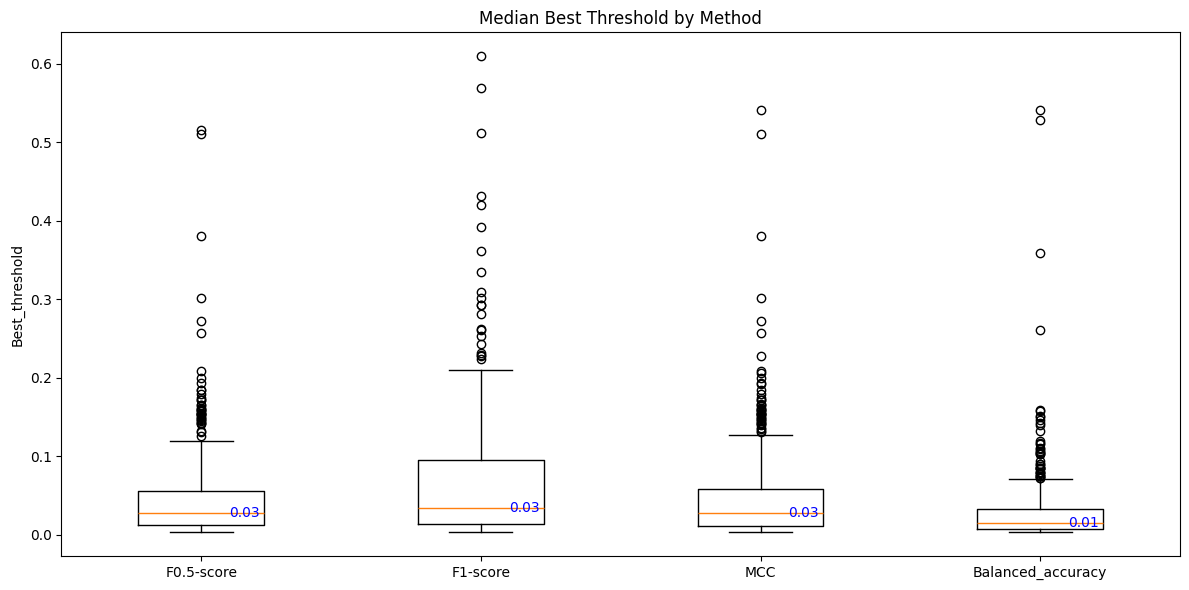

In [17]:
# boxplot for the best threshold
y_axis = "best_threshold"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Best Threshold by Method")
plt.tight_layout()
# Show the plot
plt.show()

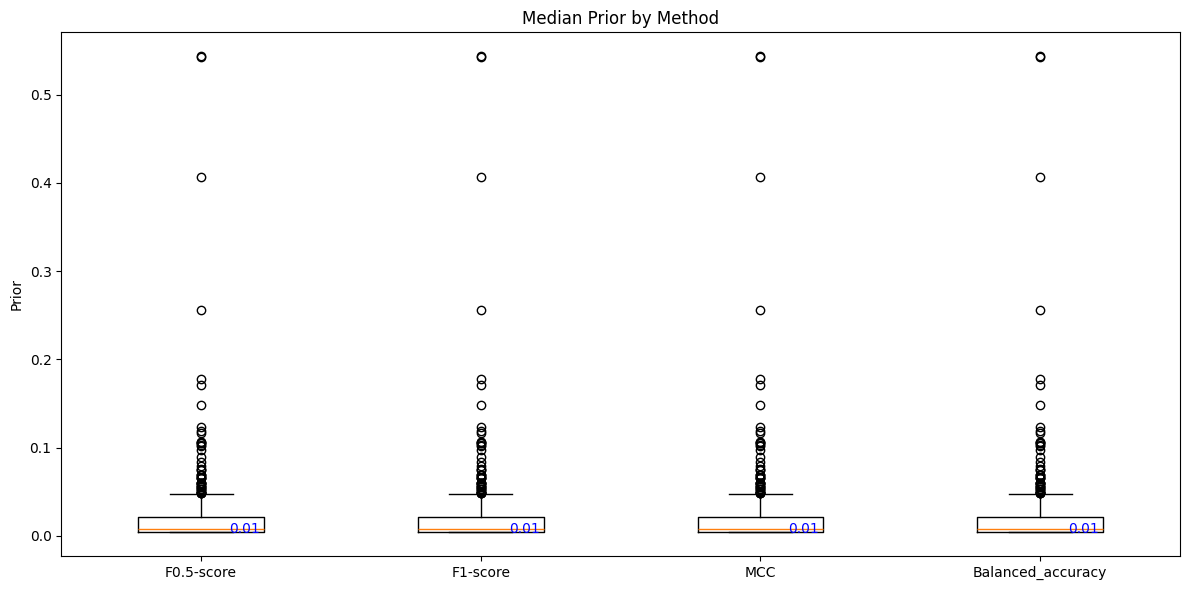

In [20]:
# boxplot for prior
y_axis = "prior"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median Prior by Method")
plt.tight_layout()
# Show the plot
plt.show()

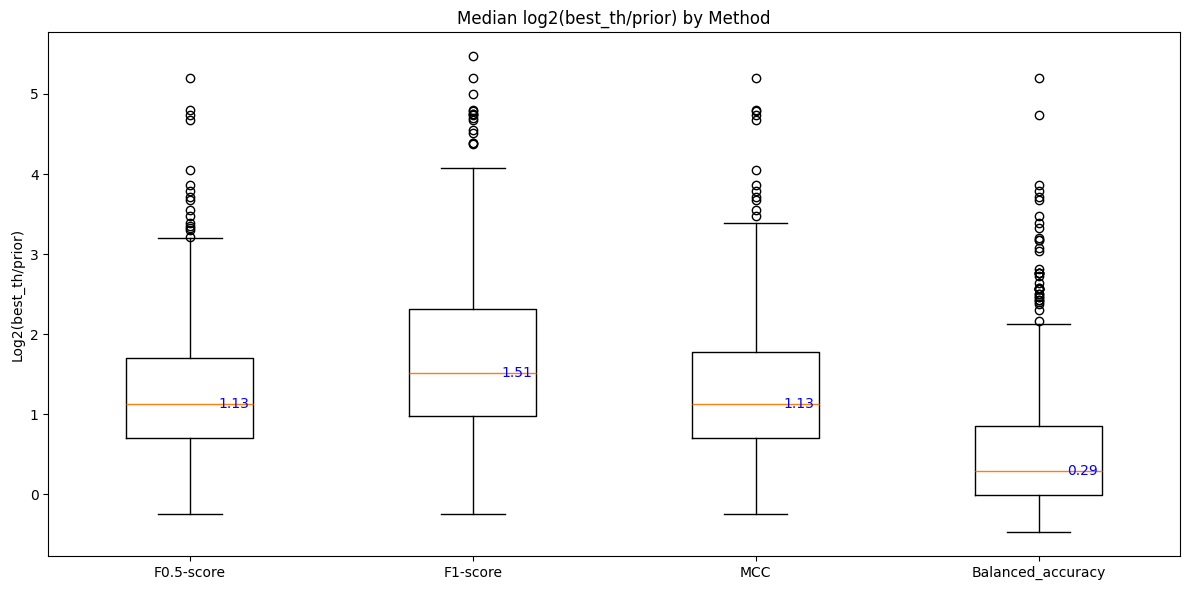

In [18]:
# boxplot for the best threshold/prior log2 ratio
y_axis = "log2(best_th/prior)"
plt.figure(figsize=(12, 6))
plt.boxplot([threshold_df[threshold_df["method"] == "f05"][y_axis], threshold_df[threshold_df["method"] == "f1"][y_axis], threshold_df[threshold_df["method"] == "mcc"][y_axis], threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis]])
median_value_f05 = threshold_df[threshold_df["method"] == "f05"][y_axis].median()
median_value_f1 = threshold_df[threshold_df["method"] == "f1"][y_axis].median()
median_value_mcc = threshold_df[threshold_df["method"] == "mcc"][y_axis].median()
median_value_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"][y_axis].median()
plt.text(1.1, median_value_f05, f"{median_value_f05:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(2.1, median_value_f1, f"{median_value_f1:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(3.1, median_value_mcc, f"{median_value_mcc:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.text(4.1, median_value_ba, f"{median_value_ba:.2f}", verticalalignment='center', fontsize=10, color='blue')
plt.xticks([1, 2, 3, 4], ['F0.5-score', 'F1-score', 'MCC', 'Balanced_accuracy'])
plt.ylabel(y_axis.capitalize())
plt.title("Median log2(best_th/prior) by Method")
plt.tight_layout()
# Show the plot
plt.show()

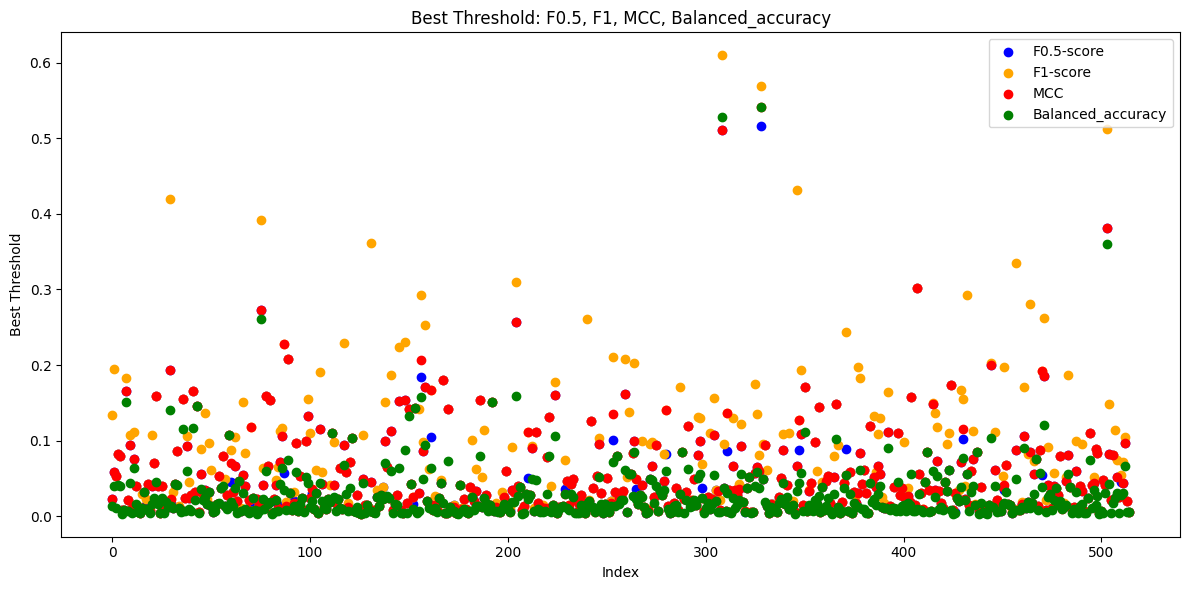

In [21]:
# scatter plot: best_threshold
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["best_threshold"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["best_threshold"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["best_threshold"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["best_threshold"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("Best Threshold")
plt.title("Best Threshold: F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

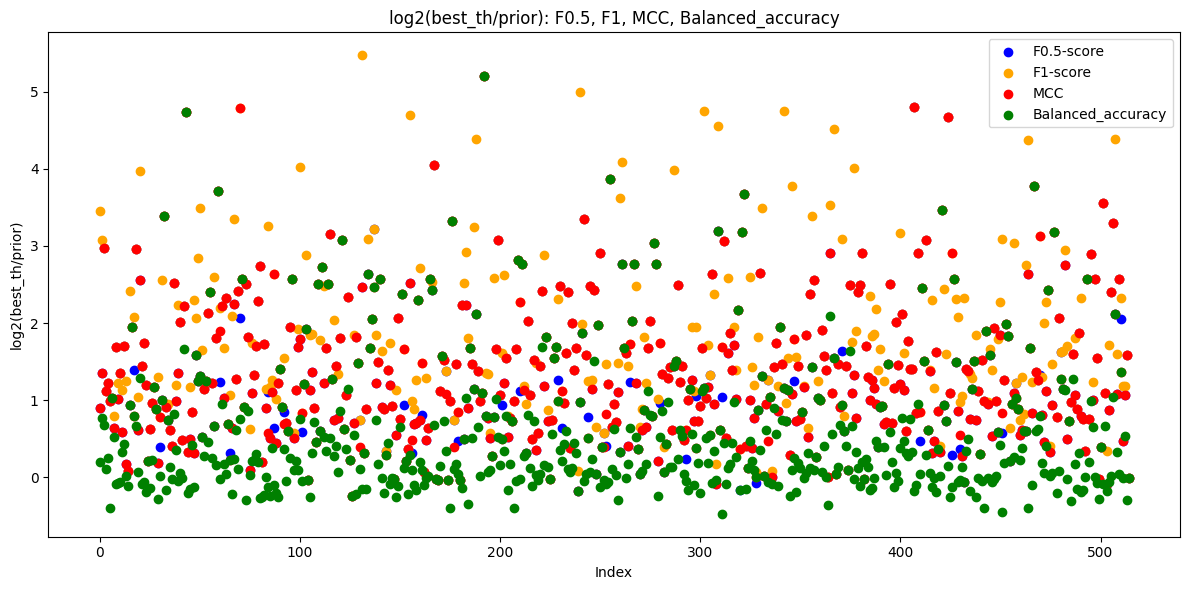

In [22]:
# scatter plot: log2(best_th/prior)
plt.figure(figsize=(12,6))
plt.scatter(threshold_df[threshold_df["method"] == "f05"].reset_index().index, threshold_df[threshold_df["method"] == "f05"]["log2(best_th/prior)"], label='F0.5-score', c="blue")
plt.scatter(threshold_df[threshold_df["method"] == "f1"].reset_index().index, threshold_df[threshold_df["method"] == "f1"]["log2(best_th/prior)"], label='F1-score', c="orange")
plt.scatter(threshold_df[threshold_df["method"] == "mcc"].reset_index().index, threshold_df[threshold_df["method"] == "mcc"]["log2(best_th/prior)"], label='MCC', c="red")
plt.scatter(threshold_df[threshold_df["method"] == "balanced_accuracy"].reset_index().index, threshold_df[threshold_df["method"] == "balanced_accuracy"]["log2(best_th/prior)"], label='Balanced_accuracy', c="green")
plt.xlabel("Index")
plt.ylabel("log2(best_th/prior)")
plt.title("log2(best_th/prior): F0.5, F1, MCC, Balanced_accuracy")
plt.legend()
plt.tight_layout()
# Show the plot
plt.show()

In [23]:
# the top terms with the highest threshold
threshold_df_top10_f05 = threshold_df[threshold_df["method"] == "f05"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_f1 = threshold_df[threshold_df["method"] == "f1"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_mcc = threshold_df[threshold_df["method"] == "mcc"].sort_values(by="best_threshold", ascending = False)["name"].head(10)
threshold_df_top10_ba = threshold_df[threshold_df["method"] == "balanced_accuracy"].sort_values(by="best_threshold", ascending = False)["name"].head(10)

In [24]:
threshold_df_top10_f05, threshold_df_top10_f1

(1873                           neoplasm
 1853     neoplastic disease or syndrome
 2048                             cancer
 1952                depressive disorder
 1620    central nervous system disorder
 1749                epithelial neoplasm
 1634          neurodegenerative disease
 1989          digestive system neoplasm
 1574                          carcinoma
 2016            glandular cell neoplasm
 Name: name, dtype: object,
 1338     neoplastic disease or syndrome
 1358                           neoplasm
 1533                             cancer
 1376                     lung carcinoma
 1059                          carcinoma
 1105    central nervous system disorder
 1161                   stomach disorder
 1487                  intestinal cancer
 1234                epithelial neoplasm
 1437                depressive disorder
 Name: name, dtype: object)

In [25]:
threshold_df_top10_mcc, threshold_df_top10_ba

(843                            neoplasm
 823      neoplastic disease or syndrome
 1018                             cancer
 922                 depressive disorder
 590     central nervous system disorder
 719                 epithelial neoplasm
 602                         lung cancer
 604           neurodegenerative disease
 671                      brain disorder
 959           digestive system neoplasm
 Name: name, dtype: object,
 328                                      neoplasm
 308                neoplastic disease or syndrome
 503                                        cancer
 75                central nervous system disorder
 204                           epithelial neoplasm
 156                                brain disorder
 7                              neoplasm of thorax
 192              differentiated thyroid carcinoma
 43                   thyroid gland adenocarcinoma
 153    hematopoietic and lymphoid system neoplasm
 Name: name, dtype: object)

In [26]:
# the top terms with the highest prior
annotation_analysis_df_top10_f05 = annotation_analysis_df[annotation_analysis_df["method"] == "f05"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_f1 = annotation_analysis_df[annotation_analysis_df["method"] == "f1"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_mcc = annotation_analysis_df[annotation_analysis_df["method"] == "mcc"].sort_values(by="prior", ascending = False)["name"].head(10)
annotation_analysis_df_top10_ba = annotation_analysis_df[annotation_analysis_df["method"] == "balanced_accuracy"].sort_values(by="prior", ascending = False)["name"].head(10)

In [27]:
annotation_analysis_df_top10_f05, annotation_analysis_df_top10_f1

(308                 neoplastic disease or syndrome
 328                                       neoplasm
 503                                         cancer
 75                 central nervous system disorder
 204                            epithelial neoplasm
 29                                       carcinoma
 156                                 brain disorder
 153     hematopoietic and lymphoid system neoplasm
 41        hematopoietic and lymphoid cell neoplasm
 36     tumor of hematopoietic and lymphoid tissues
 Name: name, dtype: object,
 1853                 neoplastic disease or syndrome
 1873                                       neoplasm
 2048                                         cancer
 1620                central nervous system disorder
 1749                            epithelial neoplasm
 1574                                      carcinoma
 1701                                 brain disorder
 1698     hematopoietic and lymphoid system neoplasm
 1586       hematopoietic an

In [28]:
annotation_analysis_df_top10_mcc, annotation_analysis_df_top10_ba

(823                  neoplastic disease or syndrome
 843                                        neoplasm
 1018                                         cancer
 590                 central nervous system disorder
 719                             epithelial neoplasm
 544                                       carcinoma
 671                                  brain disorder
 668      hematopoietic and lymphoid system neoplasm
 556        hematopoietic and lymphoid cell neoplasm
 551     tumor of hematopoietic and lymphoid tissues
 Name: name, dtype: object,
 1338                 neoplastic disease or syndrome
 1358                                       neoplasm
 1533                                         cancer
 1105                central nervous system disorder
 1234                            epithelial neoplasm
 1059                                      carcinoma
 1186                                 brain disorder
 1183     hematopoietic and lymphoid system neoplasm
 1071       hemato

### txt2onto models GT label & performance

In [29]:
# combine the best threshold, prior, ic, pos, logarprc
txt2onto_label_dfs = []
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
for m in methods:
    df = threshold_df[threshold_df["method"] == m]
    prior = []
    ic = []
    pos = []
    auprcprior = []
    for i in df["task"]:
        prior_df_sub = prior_df[["Unnamed: 0", i]]
        prior_df_sub = prior_df_sub[(prior_df_sub != 0).all(axis=1)]
        prior_df_sub[i] = prior_df_sub[i].replace(-1, 0)
        prior.append(prior_df_sub[i].mean())
        ic_value = ic_df.loc[ic_df['node'] == i, 'IC'].values[0]
        ic.append(ic_value)
        pos_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'num_of_pos'].values[0]
        pos.append(pos_value)
        auprc_value = log2auprc_df.loc[log2auprc_df['ID'] == i, 'log2(auprc/prior)'].values[0]
        auprcprior.append(auprc_value)

    # data used to train txt2onto
    txt2onto_label = pd.DataFrame({"task": df["task"], "best_threshold": df["best_threshold"], "prior": prior, "ic": ic, "num_of_pos": pos, "log2(auprc/prior)": auprcprior})
    txt2onto_label = txt2onto_label.merge(id_map, left_on="task", right_on="id", how="left")
    txt2onto_label = txt2onto_label.drop(columns=["id"])
    txt2onto_label["method"] = m
    txt2onto_label_dfs.append(txt2onto_label)
txt2onto_label_df = pd.concat(txt2onto_label_dfs, ignore_index=True)
txt2onto_label_df.head()
    

,task,best_threshold,prior,ic,num_of_pos,log2(auprc/prior),name,method
0,MONDO:0020120,0.022757,0.011697,3.846209,34,5.836350,skeletal muscle disorder,f05
1,MONDO:0700092,0.058825,0.022307,4.146013,66,5.140328,neurodevelopmental disorder,f05
2,MONDO:0005101,0.053404,0.007619,8.958197,22,6.936638,ulcerative colitis,f05
3,MONDO:0021143,0.082648,0.036997,5.286125,109,4.615338,melanocytic neoplasm,f05
4,MONDO:0005072,0.079651,0.034286,7.284221,101,4.640827,neuroblastoma,f05


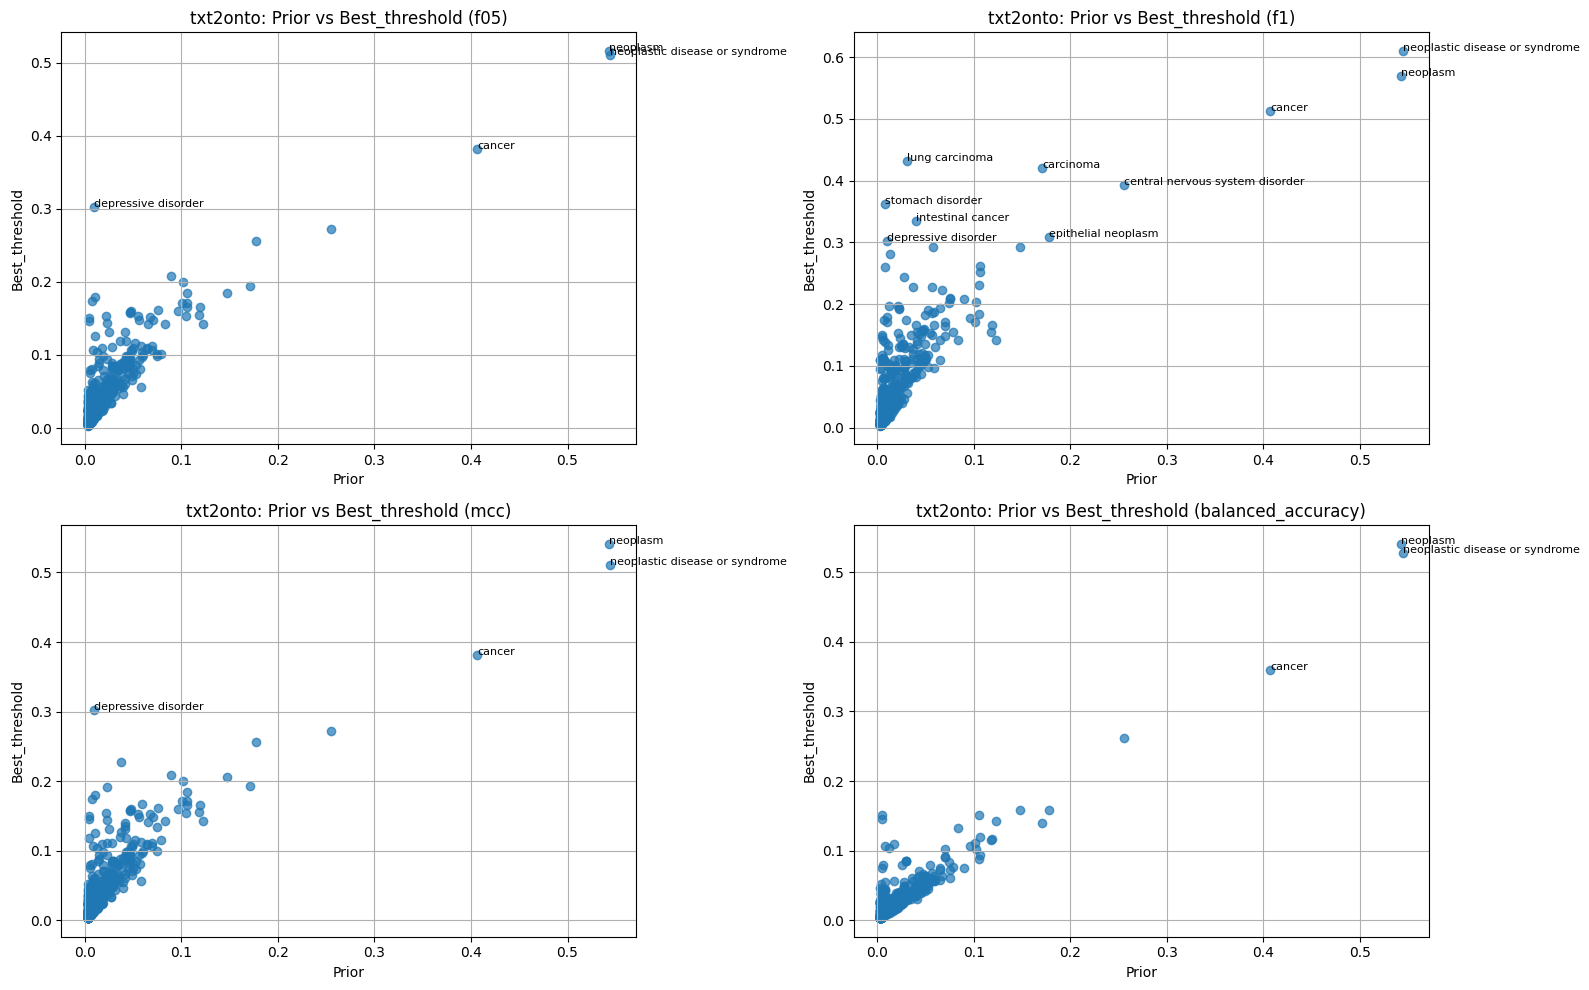

In [32]:
# Prior vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "prior"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.3:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

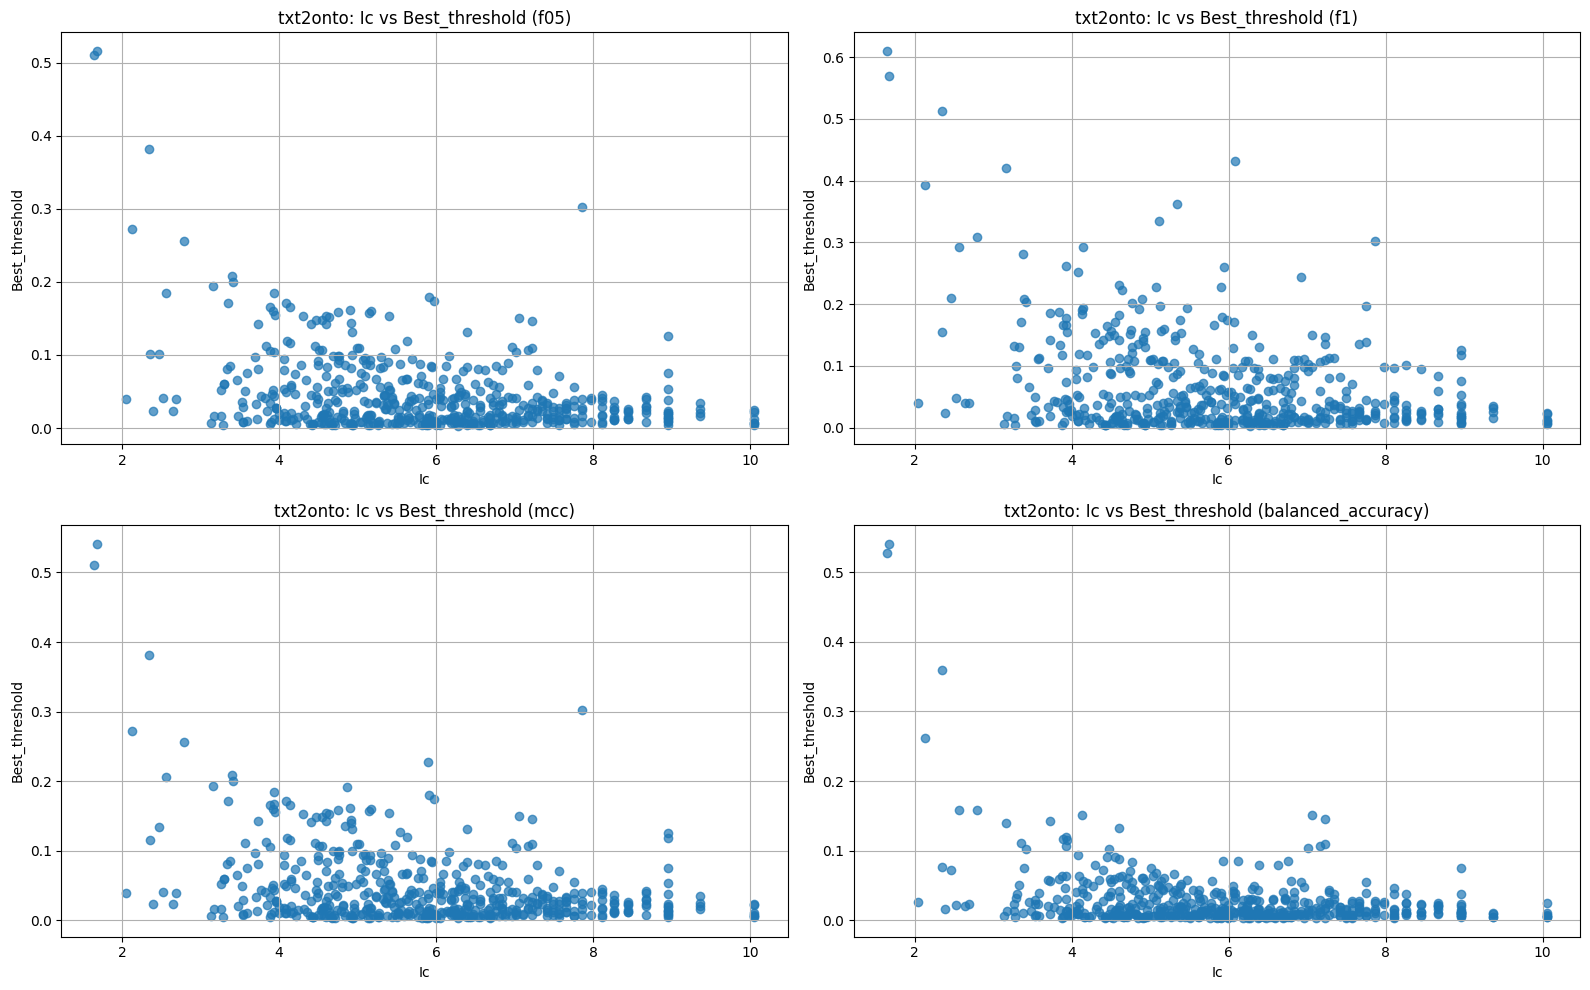

In [33]:
# Information Content vs Best Threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    # for i, row in subset.iterrows():
    #     if row[x_axis] > 0.1:
    #         plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    # if method in ["balanced_accuracy", "mcc"]:
    #     for i, row in subset.iterrows():
    #         if row[y_axis] > 0.6:
    #             plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

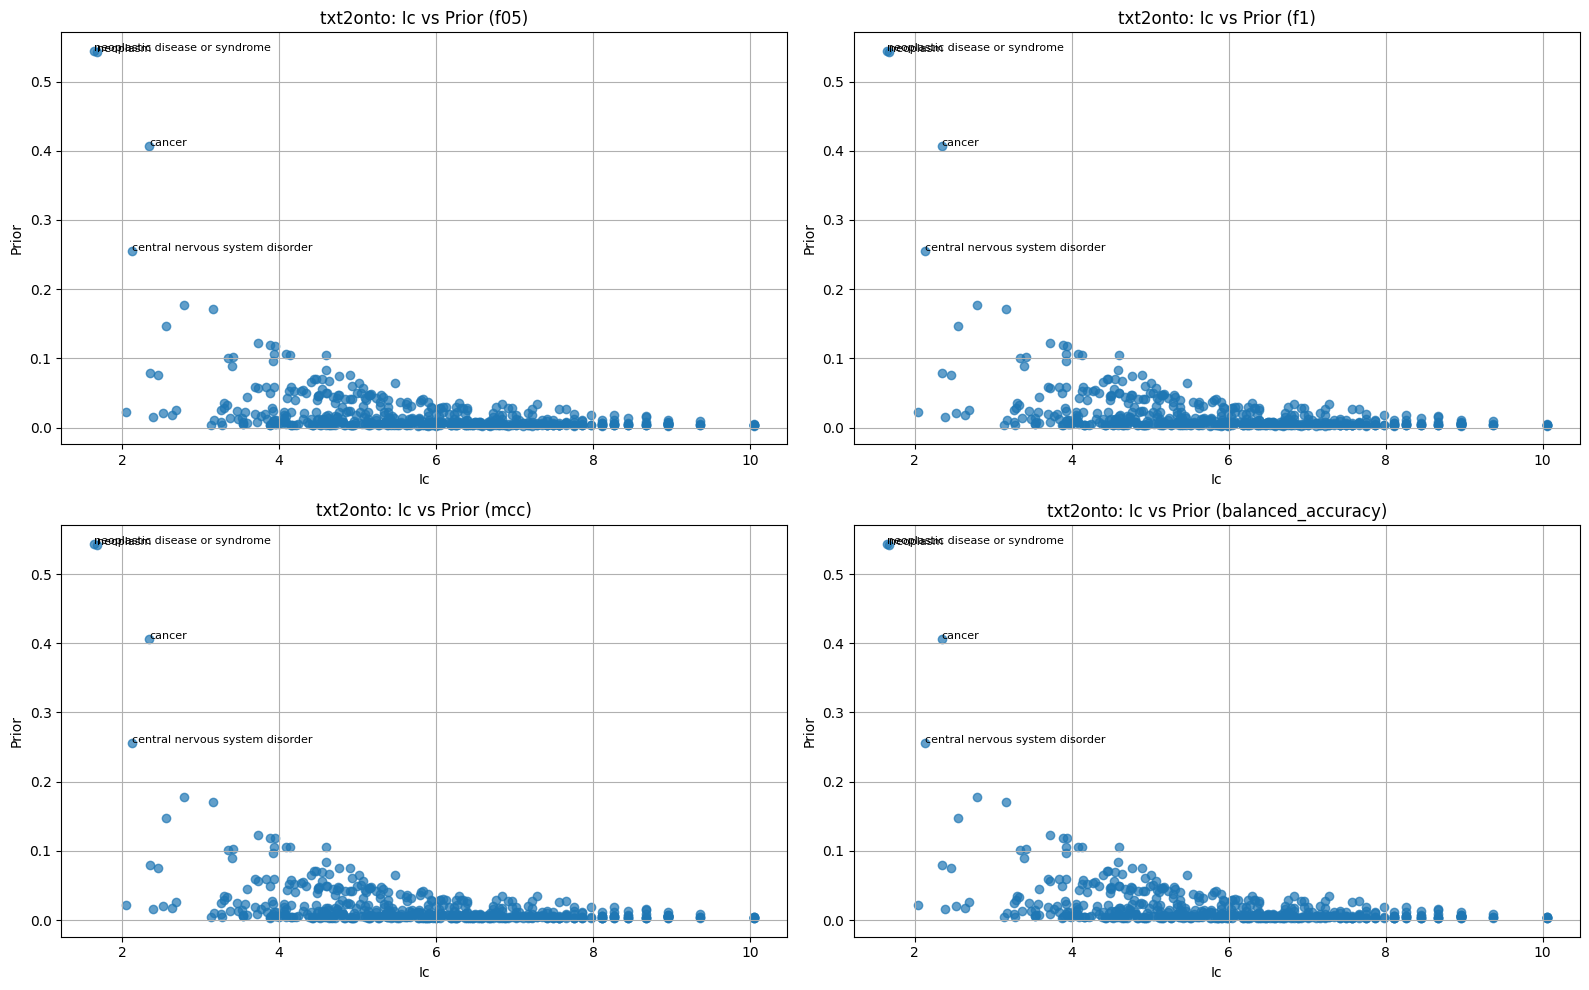

In [35]:
# IC vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "ic"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.2:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

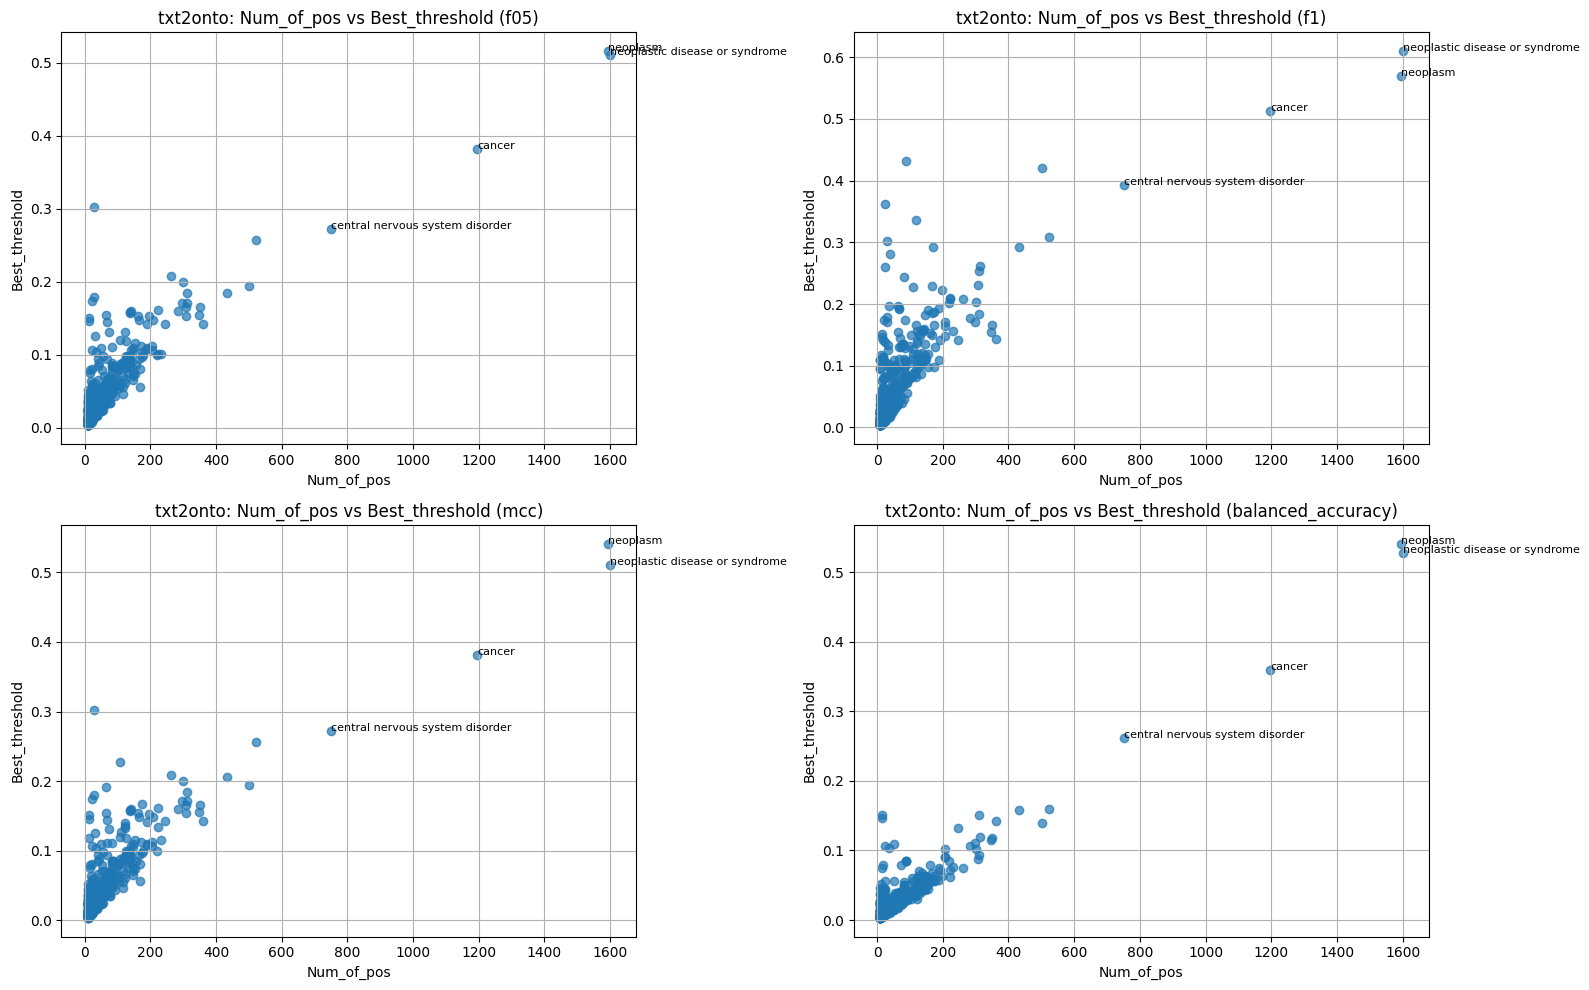

In [37]:
# Number of Positives vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "num_of_pos"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[x_axis] > 600:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

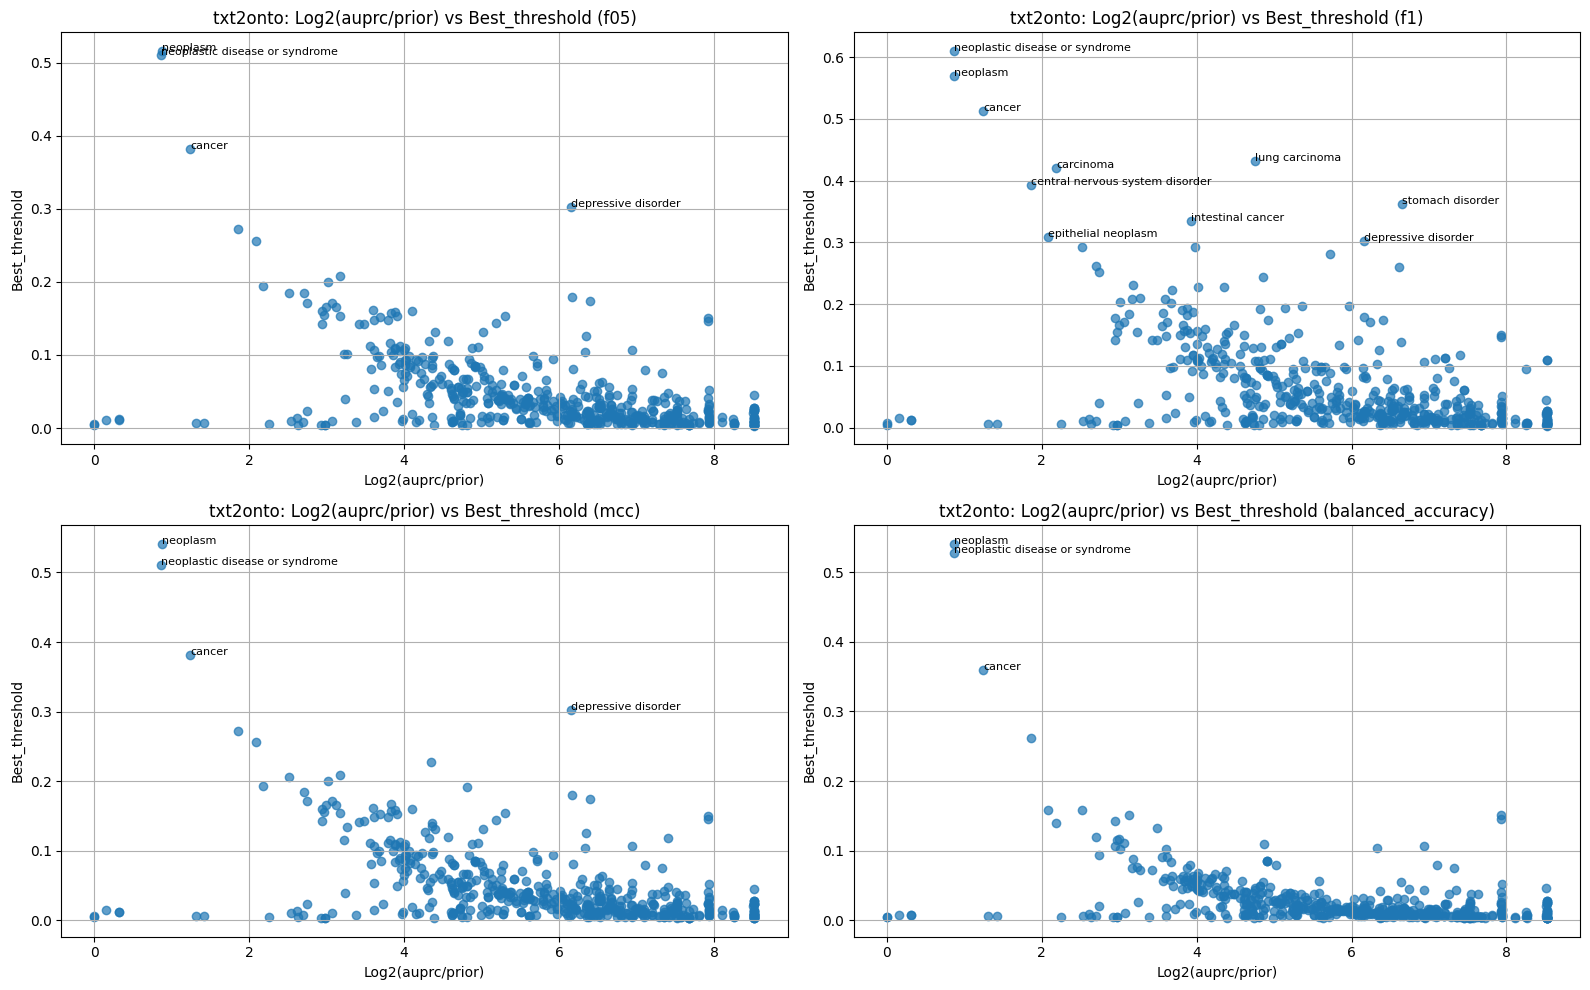

In [40]:
# log2(auprc/prior) vs best_threshold
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "log2(auprc/prior)"
y_axis = "best_threshold"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = txt2onto_label_df[txt2onto_label_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.3:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'txt2onto: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

### GEO studies: predicted annotations

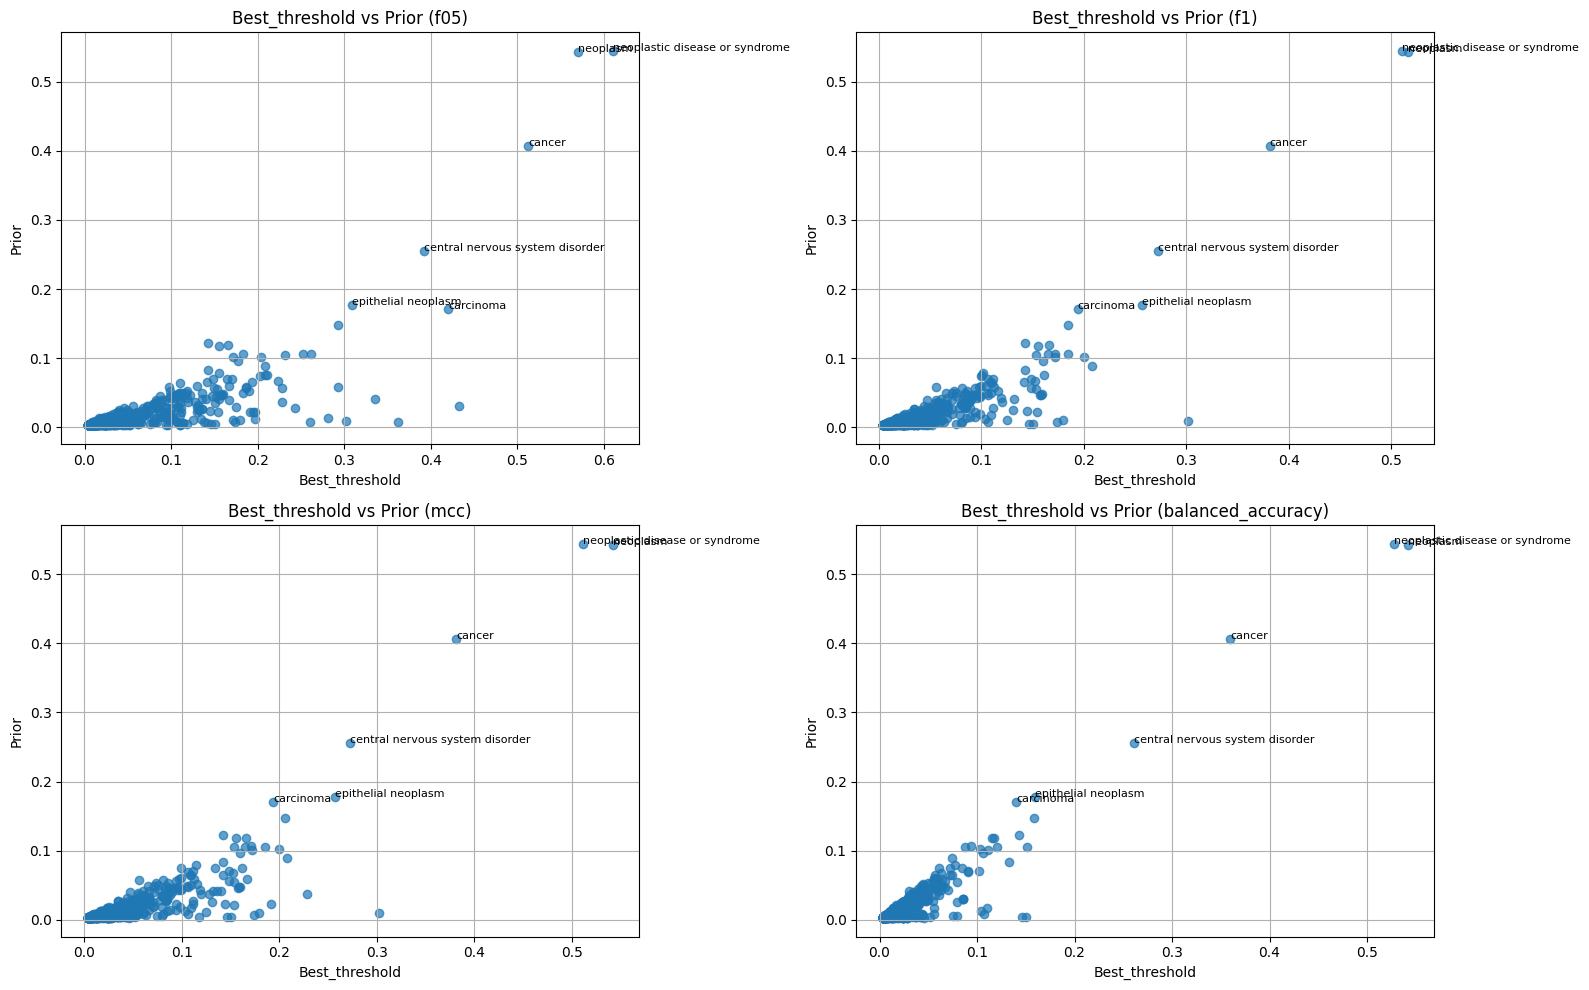

In [60]:
# best_threshold vs Prior
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "prior"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 0.15:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    if method in ["balanced_accuracy", "mcc"]:
        for i, row in subset.iterrows():
            if row[x_axis] > 0.6:
                plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()


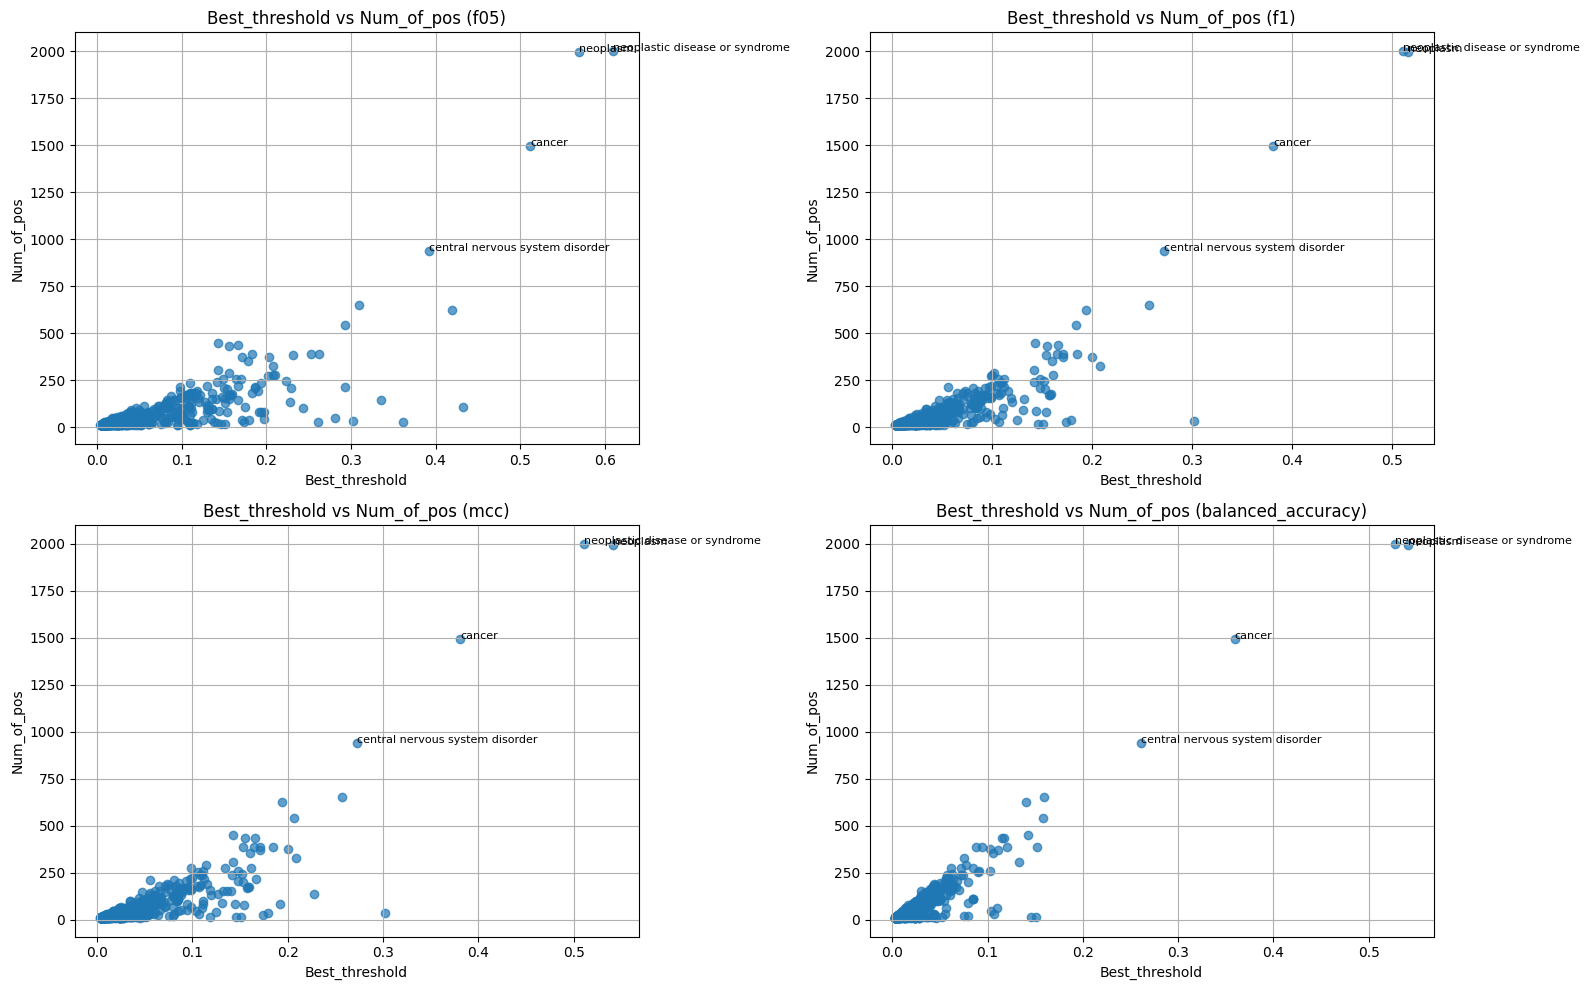

In [59]:
# best_threshold vs Number of Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 750:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'{x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()

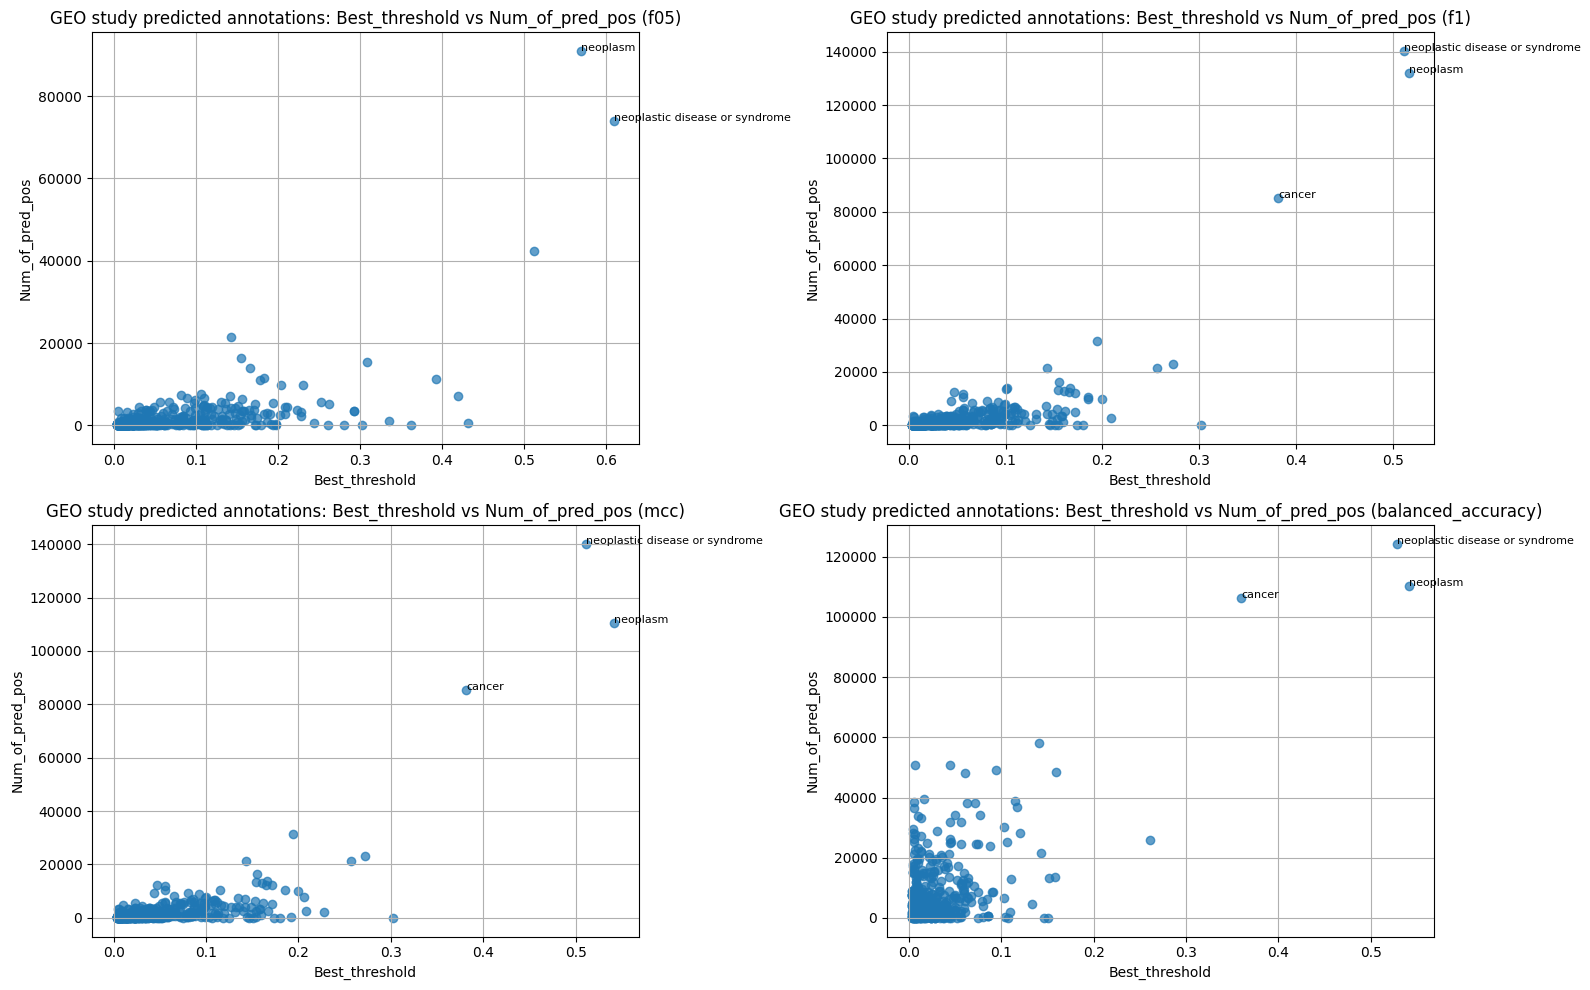

In [63]:
# best_threshold vs Number of Predicted Positives
methods = ["f05", "f1", "mcc", "balanced_accuracy"]
x_axis = "best_threshold"
y_axis = "num_of_pred_pos"
plt.figure(figsize=(16, 10))

for i, method in enumerate(methods, 1):
    subset = annotation_analysis_df[annotation_analysis_df["method"] == method]
    plt.subplot(2, 2, i)
    plt.scatter(subset[x_axis], subset[y_axis], alpha=0.7)
    for i, row in subset.iterrows():
        if row[y_axis] > 60000:
            plt.text(row[x_axis], row[y_axis], row['name'], fontsize=8, ha='left')
    plt.xlabel(x_axis.capitalize())
    plt.ylabel(y_axis.capitalize())
    plt.title(f'GEO study predicted annotations: {x_axis.capitalize()} vs {y_axis.capitalize()} ({method})')
    plt.grid(True)

plt.tight_layout()
plt.show()